# Modelo de predicción de impago de usuarios de tarjeta de  credito
## Resumen
El princpial objetivo de este proyecto es implementar algoritmos de inteligencia artificial para la predicción del posible impago en la próxima cuota de la tarjeta de crédito, basandose en diferentes factores, tales como: edad, nivel educativo, sexo, cupo de la tarjeta y pago realizados en los meses anteriores.
Para la realización de este proyecto, se tomó la información de 30000 personas y el análisis se va a llevar a cabo en el lenguaje de programación Python.

## Fuente de los datos
La información fue obtenida de la base de datos de la Universidad de California a través de la siguiente dirección: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## Importación de los paquetes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import os
from sklearn.preprocessing import normalize, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import logging
import warnings  


## Carga de la información
Para la importación del Dataset se usa la libreria Pandas

In [3]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
datos=pd.read_excel(url) # Leer desde la URL
datos.columns=list(datos.loc[0])
datos=datos.drop(0,axis=0)


In [4]:
datos.describe()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,30000,81,2,7,4,56,11,11,11,11,...,21548,21010,20604,7943,7899,7518,6937,6897,6939,2
top,30000,50000,2,2,2,29,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,1,3365,18112,14030,15964,1605,14737,15730,15764,16455,...,3195,3506,4020,5249,5396,5968,6408,6703,7173,23364


## Verificación de valores nulos
Se busca el número de valores nulos o NaNs para su posterior eliminación o reemplazo dependiendo del porcentaje faltante

In [5]:
# Encuentra el número de valores nulos para cada columna
datos.isnull().sum(axis=0) # No existen ningún valor nulo

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Para este dataset no se encuentra ningún valor nulo

## Exploración de datos
Se grafican ciertas variables para observar su comportamiento y detectar alguna anormalidad o tendencia. Para esto, se hace uso de las librerias Matplotlib y Seaborn.

### Gráfico del total de personas en diferentes categorias
Se va a mostrar el total de clientes categorizados de diferentes formas, por ejemplo, edad y estado civil. Se van a diferenciar las personas que cumplieron  con su pago (azul), de las que no (naranja).

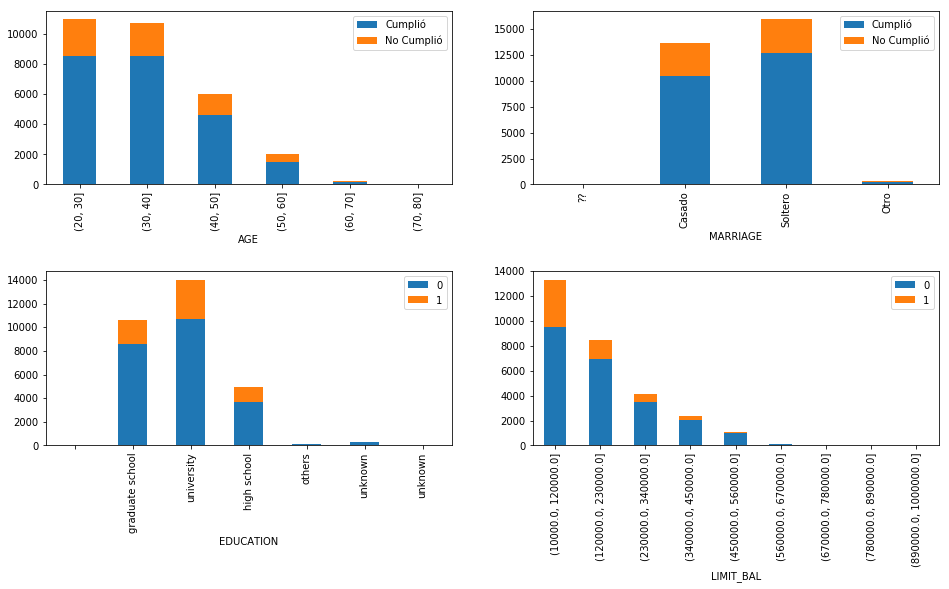

In [6]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=[16,8])
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Gráfico por edades con el total de las personas. Se diferencia el número de personas que han pagado y las que no
bins=pd.cut(datos["AGE"],[20,30,40,50,60,70,80])
age_count=datos.groupby(bins)["default payment next month"].agg(["count","sum"])
age_count["count"]=age_count["count"]-age_count["sum"]
ax=age_count.plot.bar(stacked=True,ax=ax1)
ax.legend(["Cumplió","No Cumplió"])

# Gráfico en función del estado civil con el total de las personas. Se diferencia el número de personas que han pagado y las que no
marriage_count=datos.groupby(["MARRIAGE"])["default payment next month"].agg(["count","sum"])
marriage_count["count"]=marriage_count["count"]-marriage_count["sum"]
ax1=marriage_count.plot.bar(stacked=True,ax=ax2)
ax1.legend(["Cumplió","No Cumplió"])
ax1.set_xticklabels(["??","Casado","Soltero","Otro"])

# Gráfico en función del nivel de educación con el total de las personas.
gender_education=datos.groupby(["EDUCATION"])["default payment next month"].agg(["count","sum"])
gender_education["count"]=gender_education["count"]-gender_education["sum"]
ax2=gender_education.plot.bar(stacked=True,ax=ax3)
ax2.legend(["0","1"])
ax2.set_xticklabels([" ","graduate school", "university", "high school", "others", "unknown", "unknown"])

# Gráfico en función del cupo de la tarjeta con el total de las personas.
max,min=[datos["LIMIT_BAL"].max(),datos["LIMIT_BAL"].min()]
space=np.linspace(min,max,10)

bins=pd.cut(datos["LIMIT_BAL"],space)
LIMIT_BAL=datos.groupby(bins)["default payment next month"].agg(["count","sum"])
LIMIT_BAL["count"]=LIMIT_BAL["count"]-LIMIT_BAL["sum"]
ax3=LIMIT_BAL.plot.bar(stacked=True,ax=ax4)
ax3.legend(["0","1"])


En el primer análisis exploratorio, se puede ver que existenn ciertas tendencias principalmente en la edad y en la capacidad de la tarjeta. Siendo la gente joven y las personas con menos cupos las que más incumplen con sus pagos.
Por otro lado, se puede observar un valor que no corresponde a ningún grupo en la gráfica de matrimonio, estos valores serán reemplazados el más común dentro de esa columna. 
También es posible ver la existencia de distintas variables categoricas, por lo que es necesario la creación de variables dummies.


### Correlación de variables
Se va a graficar la correlación que existe entre en el valor de las facturas de la tarjeta para distintos meses

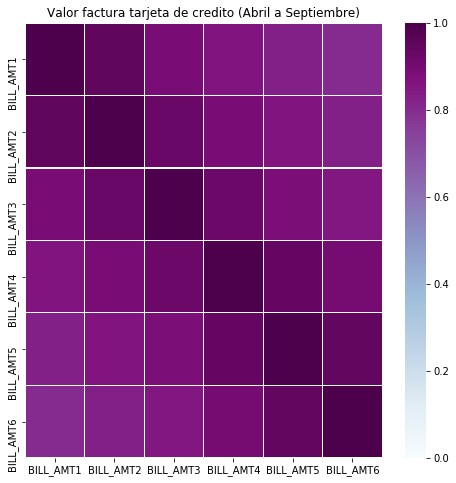

In [7]:
variables=["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
plt.figure(figsize=(8,8))
plt.title("Valor factura tarjeta de credito (Abril a Septiembre)")
datos[variables] = datos[variables].astype(float)
correlation=datos[variables].corr()
sns.heatmap(correlation,xticklabels=correlation.columns,yticklabels=correlation.columns,linewidths=.1,vmin=0, vmax=1,cmap="BuPu")
plt.show()





Es posible observar que existe una correlación entre estas varibales, la cual decrece con la distancia entre meses. 
La menor correlación es entre los meses de Abril y Septiembre

## Limpieza de datos
Creación de variables dummies y eliminación o reemplazo de valores que no corresponden a ninguna variable

In [8]:
datos["MARRIAGE"]=datos["MARRIAGE"].replace(0,2)  # Reemplazo los ceros por el valor más común

# PASAR LAS VARIABLES CATEOGRICAS A DUMMIES
datos=pd.get_dummies(datos,prefix="SEX",columns=["SEX"])
DataFrame=pd.get_dummies(datos,prefix="MARRIAGE",columns=["MARRIAGE"])

# ELIMINAMOS UNA DUMMY VARIABLE DE CADA CONJUNNTO
DataFrame=DataFrame.drop("MARRIAGE_3",axis=1)
DataFrame=DataFrame.drop("SEX_2",axis=1)

# Eliminamos la variable ID del DataSet a estudiar, ya que no es relevante para la implementación del modelo y puede causar errores en los modelos de predicción
DataFrame=DataFrame.drop("ID",axis=1)

# Creamos un array X, con las varibales predictoras y uno Y con la variable a predecir
column_names=DataFrame.columns.values.tolist()
Y=["default payment next month"]
X=[i for i in column_names if i not in Y ]


## División de los datos entre entrenamiento y validación

In [9]:
# Dividimos los datos con scikit learn, un 30% de los datos serán destinados a validación y un random state=0 para poder replicar resultados después 
X_train,X_test,Y_train,Y_test=train_test_split(DataFrame[X],DataFrame["default payment next month"],test_size=0.3,random_state=0)


## Escalado de variables
Se hace un escalado de variables ya que existe una disperción muy grande entre los valores del dataset. 

In [10]:

scaler=Normalizer()
X_train[X_train.columns]=scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns]=scaler.fit_transform(X_test[X_test.columns])


# Modelos predictivos
Para el análisis de este dataset se van a utilizar tres algotirmos, los cuales son:
- Regresión Logística
- Random Forest
- Redes Neuronales

## Regresión logística

Exactitud: 78.43333333333334 %


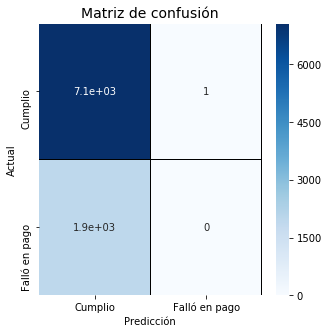

In [11]:
# Selección de varibales
# Se usa el módulo de ScikitLearn RFE Recursive Feature Elimination
modelo=LogisticRegression(solver="liblinear")
rfe=RFE(modelo,int(X_train.shape[1]))
Y_train=Y_train.astype(int)
rfe=rfe.fit(X_train,Y_train)
variables_to_use=rfe.support_
rank_variables=rfe.ranking_  # Según el modelo todas las variables aportan información

lm=modelo.fit(X_train,Y_train)
prediccione=lm.predict(X_test)
print("Exactitud:",lm.score(X_test,Y_test.astype(int))*100,"%")  #  Exactitud del modelo con los datos de testing # Reaultado :0.7843333

#Matriz de confusión

cross=pd.crosstab(Y_test,prediccione,rownames=["Actual"],colnames=["Predicción"])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cross,xticklabels=['Cumplio', 'Falló en pago'],
            yticklabels=['Cumplio', 'Falló en pago'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="black", cmap="Blues")
plt.title("Matriz de confusión", fontsize=14)
plt.show()


### Medida a través del área bajo la curva (AUC-ROC)

In [12]:
roc_auc_score(Y_test.astype(int), prediccione)

0.499929178470255

## Random Forest

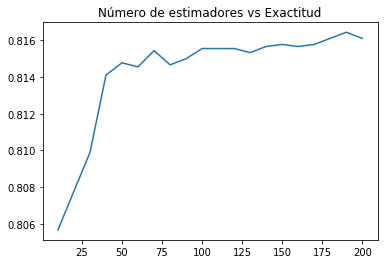

In [13]:
# Para esto, importamos de ScikitLearn la función RandomForestClssifier
Pred=[]
i=0
vec=np.linspace(10,200,20)
for n_estimators in vec:  # Loop para encontrar el número óptimo de árboles en el forest
    i+=1
    RF=RandomForestClassifier(n_estimators=int(n_estimators),random_state=0) 
    RF.fit(X_train,Y_train)

    # Predicciones con Random forest

    predicciones=RF.predict(X_test)
    # Exactitud del modelo
    Exac=RF.score(X_test,Y_test.astype(int))
    Pred.append(Exac)

plt.plot(vec,Pred)
plt.title("Número de estimadores vs Exactitud")
plt.show()

Se hace uso de un loop con el fin de encontrar el número óptimo de estimadores, y lograr una mejor eficiencia en terminos computacionales y una exactitud aceptable. Es posible observar que déspues de 50 estimadores(árboles) la exactitud tiende a estabilizarse, por lo que el número de estimadores seleccionado es de 50.

### Matriz de confusión

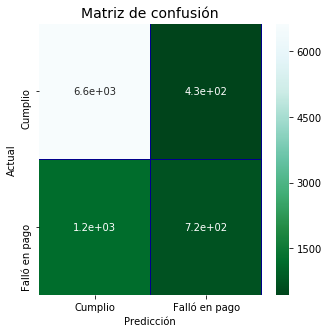

In [14]:
cross=pd.crosstab(Y_test,predicciones,rownames=["Actual"],colnames=["Predicción"])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cross,xticklabels=['Cumplio', 'Falló en pago'],
            yticklabels=['Cumplio', 'Falló en pago'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="BuGn_r")
plt.title("Matriz de confusión", fontsize=14)
plt.show()


### Medida a través del área bajo la curva (AUC-ROC)

In [15]:
roc_auc_score(Y_test.astype(int), predicciones)

0.6543858240121492

El AUC-ROC para Random Forest es de 0.65

## Redes Neuronales
Se va a utilizar Redes Neuronales densas o totalmente conectadas

In [16]:
num_features=int(X_train.shape[1])
num_features=24
num_labels=int(np.unique(Y_train).shape[0])
num_labels=2
# Se asignan como "Features" las siguientes varibales
LIMIT_BAL = tf.feature_column.numeric_column('LIMIT_BAL')
EDUCATION = tf.feature_column.numeric_column('EDUCATION')
AGE = tf.feature_column.numeric_column('AGE')
PAY_0 = tf.feature_column.numeric_column('PAY_0')
PAY_2 = tf.feature_column.numeric_column('PAY_2')
PAY_3 = tf.feature_column.numeric_column('PAY_3')
PAY_4 = tf.feature_column.numeric_column('PAY_4')
PAY_5 = tf.feature_column.numeric_column('PAY_5')
PAY_6 = tf.feature_column.numeric_column('PAY_6')
BILL_AMT1 = tf.feature_column.numeric_column('BILL_AMT1')
BILL_AMT2 = tf.feature_column.numeric_column('BILL_AMT2')
BILL_AMT3 = tf.feature_column.numeric_column('BILL_AMT3')
BILL_AMT4 = tf.feature_column.numeric_column('BILL_AMT4')
BILL_AMT5 = tf.feature_column.numeric_column('BILL_AMT5')
BILL_AMT6 = tf.feature_column.numeric_column('BILL_AMT6')
PAY_AMT1=tf.feature_column.numeric_column('PAY_AMT1')
PAY_AMT2=tf.feature_column.numeric_column('PAY_AMT2')
PAY_AMT3=tf.feature_column.numeric_column('PAY_AMT3')
PAY_AMT4=tf.feature_column.numeric_column('PAY_AMT4')
PAY_AMT5=tf.feature_column.numeric_column('PAY_AMT5')
PAY_AMT6=tf.feature_column.numeric_column('PAY_AMT6')
SEX_1=tf.feature_column.numeric_column('SEX_1')
MARRIAGE_1=tf.feature_column.numeric_column('MARRIAGE_1')
MARRIAGE_2=tf.feature_column.numeric_column('MARRIAGE_2')


featuresColumns=[LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,MARRIAGE_1,MARRIAGE_2]

# Para el entrenamiento de la Red Neuronal se van a utilizar los siguientes parámetros:
    # Batch Size=100
    # Epochs=1000
    # Número de Neuronas: Primera Capa 512
    #                     Segunda Capa 256
    #                     Tercera Capa 128
    #Learning rate=0.001
# Estos valores se pueden modificar para buscar mejores resultados
input_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=Y_train.astype(int),batch_size=100,num_epochs=1000,shuffle=True)

DNNClassifier=tf.estimator.DNNClassifier(hidden_units=[512,256,128],
                                         feature_columns=featuresColumns,
                                         n_classes=2,
                                         activation_fn=tf.nn.tanh,
                                         optimizer=lambda :tf.train.AdamOptimizer(
                                             learning_rate=0.001
                                         )

                                         )
DNNClassifier.train(input_fn=input_func,steps=1000)

funcion_evaluacion=tf.estimator.inputs.pandas_input_fn(x=X_test,y=Y_test.astype(int),batch_size=100,num_epochs=1,shuffle=True)
#print(DNNClassifier.evaluate(funcion_evaluacion))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\X510UA\\AppData\\Local\\Temp\\tmph35asfb0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000241A8A34668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To

{'accuracy': 0.78422225, 'accuracy_baseline': 0.78444445, 'auc': 0.63449854, 'auc_precision_recall': 0.29912734, 'average_loss': 0.5053663, 'label/mean': 0.21555555, 'loss': 50.536633, 'precision': 0.25, 'prediction/mean': 0.18882477, 'recall': 0.00051546394, 'global_step': 1000}

### Matriz de confusión

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\X510UA\AppData\Local\Temp\tmph35asfb0\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


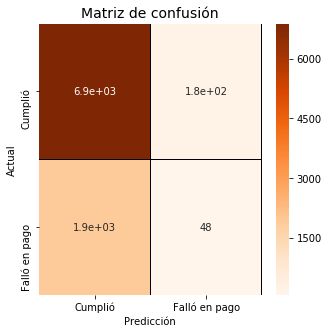

In [20]:
list_pred=[]
predicciones_NN=DNNClassifier.predict(funcion_evaluacion);

for i in predicciones_NN:
    predicted_class = i['class_ids']
    probability = i['probabilities']
    val=probability.argmax()
    list_pred.append(predicted_class)


import seaborn as sns
Predicciones_NN_array=np.array(list_pred).T.flatten()
dd=pd.Series(list_pred)
cross=pd.crosstab(Y_test,Predicciones_NN_array,rownames=["Actual"],colnames=["Predicción"])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cross,xticklabels=['Cumplió', 'Falló en pago'],
            yticklabels=['Cumplió', 'Falló en pago'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="black", cmap="Oranges")
plt.title("Matriz de confusión", fontsize=14)
plt.show()

In [19]:
roc_auc_score(Y_test.astype(int), Predicciones_NN_array)

0.49830904471247917

# Conclusiones y observaciones relevantes
- Las personas jovenes son las que más uso hacen de este tipo de productos y a su vez las que más incumplen con el pago
- De igual manera, existe un mayor número de personas con un cupo bajo y estas son las que más incumplen con el pago en comparación con las personas de cupos mayores
- Al momento de realizar el análisis predictivo, se encuentra que el algoritmo de Random Forest es el que mejor resultados presenta, con un valor de área de bajo la curva (ROC-AUC) mayor que el obtenido en la Regresión Logistica y en Redes Neuronales